f# Ted Bakes Cakes - Labor Hours Forecaster

In [4]:
# Python Basics
import yaml
import logging
import sys
import os
from datetime import datetime
import pytz

# Pandas
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 20)  # 20 columns
pd.set_option('display.width', 120)  # 120 characters
pd.set_option('display.max_rows', 500)
from pandas import ExcelWriter
from pandas import ExcelFile

# Sklearn Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression # for testing only

# Sklearn Model Selection
from sklearn.model_selection import cross_val_score

# Sklearn Classifiers
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Sklearn metrics
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import r2_score,mean_squared_error

# mlxtend - for min_max scaling
from mlxtend.preprocessing import minmax_scaling
from mlxtend.classifier import StackingClassifier

# Statsmodels
import statsmodels.api as sm # For Linear Regression
#import statsmodels.tools.eval_measures
#from statsmodels.tools.eval_measures import meanabs
from statsmodels.tools.eval_measures import meanabs

# Plotting modules
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
plt.rc("font", size=14)

# Contingency Table|
from scipy.stats import fisher_exact

# Missing data plotting
import missingno as mgno



In [5]:
def read_logbook(logbook_file_name, data_sheet_name):
    """
    Read a list of logbook entries from Ted's logbook
    Fields are Type1, Type2, Type3, Type4, TotalCakes, TotalHours
    Type1, Type2, Type3, Type4, TotalCakes are integer values
    TotalHours is a real value
    We are using Type1, Type2, Type3, Type4 to predict TotalHours
    We read the values here into a Pandas dataframe object.
    """
    logging.info(str(datetime.now()) + ' read_logbook: ' + str(logbook_file_name) + 'sheet: ' + data_tab_name)
    print(f'read_logbook opening logbook: {logbook_file_name} sheet: {data_tab_name}')

    try:
        logbook = pd.read_excel(logbook_file_name, sheet_name=data_tab_name, header=0, converters={'Type1': float,
                                          'Type2': float, 'Type3': float, 'Type4': float,
                                          'TotalCakes': float,'TotalHours': float})
    
    except Exception as e:
        print(f'Exception is {e}')
        print("Problem during logbook read from Excel, or just after")
        print(f'Check logbook file name and tab name selected.')
        logging.info(str(datetime.now()) + ' read_logbook stopping on exception: ' + e)
        raise SystemExit

    else:
        return logbook

In [6]:
def colinearity_check(feature_names, target_df):
    
    """
    Check for Colinearity
    Look for strong correlations between features using Pearson correlation
    
    """
    
    feature_corrs = target_df[feature_names].corr()
    fig, ax = plt.subplots(figsize=(14,14)) 
    sns.heatmap(feature_corrs, vmin=-1, cmap='coolwarm', annot=False, ax=ax, linewidth=0.05)
    plt.show()
    
    return feature_corrs

In [7]:
# Open and Read Config File
DEBUG = 1
config_file_name = 'cakes.yaml'
try:
    with open(config_file_name, 'r') as config_file:
        config = yaml.safe_load(config_file)
        config_file.close()
        DEBUG = config['Run_Time']['DEBUG']

except Exception as e:
    print('cakes exiting - cannot read config file', file=sys.stderr)
    print('Error is:', e, file=sys.stderr)
    sys.exit("Config file not found")

# Set tab names
logbook_file_name = config['File_Locations']['logbook']
data_tab_name = config['Tabs']['data_tab']

In [8]:
print(logbook_file_name, data_tab_name)

/Users/brucebrownlee/Dev/Code/Github/Ted-Bakes-Cakes-Python/logbook.xlsx RawData


## Read the Data

In [9]:
logbook = read_logbook(logbook_file_name, data_tab_name)

read_logbook opening logbook: /Users/brucebrownlee/Dev/Code/Github/Ted-Bakes-Cakes-Python/logbook.xlsx sheet: RawData


## Add a Term to Let Model Estimate Bake Oven Conflict Effects

In [10]:
# Add Baking Conflict Delay Term
logbook['Delay'] = logbook[['Type 2', 'Type 3']].min(axis=1)

In [11]:
# Define Feature Columns

feature_names = ['Type 1', 'Type 2', 'Type 3', 'Type 4', 'Delay']

## Examine the Data

In [13]:
# Show Data

display(logbook.head(10))
display(logbook.describe())

,Type 1,Type 2,Type 3,Type 4,Total Cakes,Total Hours,Delay
0,4,1,2,3,10,8.1,1
1,3,1,2,2,8,6.7,1
2,3,0,3,3,9,7.5,0
3,4,0,1,3,8,4.5,0
4,2,1,1,2,6,5.0,1
5,4,3,0,2,9,7.7,0
6,4,2,2,3,11,10.2,2
7,4,1,2,3,10,10.4,1
8,3,2,0,3,8,8.2,0
9,3,1,0,3,7,4.6,0


,Type 1,Type 2,Type 3,Type 4,Total Cakes,Total Hours,Delay
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,2.946667,1.166667,1.160000,2.463333,7.736667,6.718333,0.663333
std,1.006910,0.884021,0.889026,1.154599,1.957916,2.413153,0.666937
min,1.000000,0.000000,0.000000,0.000000,2.000000,0.500000,0.000000
25%,2.000000,0.000000,0.000000,2.000000,6.000000,5.075000,0.000000
50%,3.000000,1.000000,1.000000,3.000000,8.000000,6.700000,1.000000
75%,4.000000,2.000000,2.000000,3.000000,9.000000,8.200000,1.000000
max,5.000000,3.000000,3.000000,5.000000,14.000000,14.800000,3.000000


## View Data Counts by Value

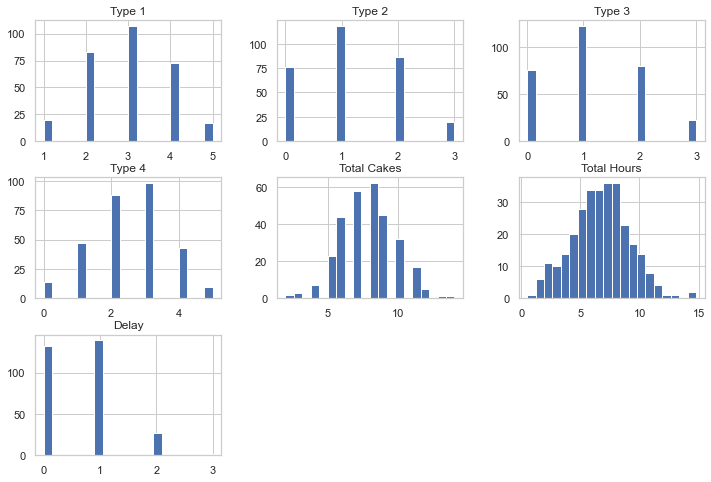

In [14]:
logbook.hist(figsize=(12,8), bins=20)
plt.show()

## Check Correlation to Target and Collinearity Between Features

In [15]:
# Check Correlation to Target

display(np.corrcoef(logbook['Total Hours'], logbook['Type 1']))
display(np.corrcoef(logbook['Total Hours'], logbook['Type 2'])) 
display(np.corrcoef(logbook['Total Hours'], logbook['Type 3'])) 
display(np.corrcoef(logbook['Total Hours'], logbook['Type 4']))
display(np.corrcoef(logbook['Total Hours'], logbook['Delay']))

array([[1.        , 0.21925561],
       [0.21925561, 1.        ]])

array([[1.        , 0.48159147],
       [0.48159147, 1.        ]])

array([[1.        , 0.49312376],
       [0.49312376, 1.        ]])

array([[1.       , 0.4193489],
       [0.4193489, 1.       ]])

array([[1.        , 0.65220418],
       [0.65220418, 1.        ]])

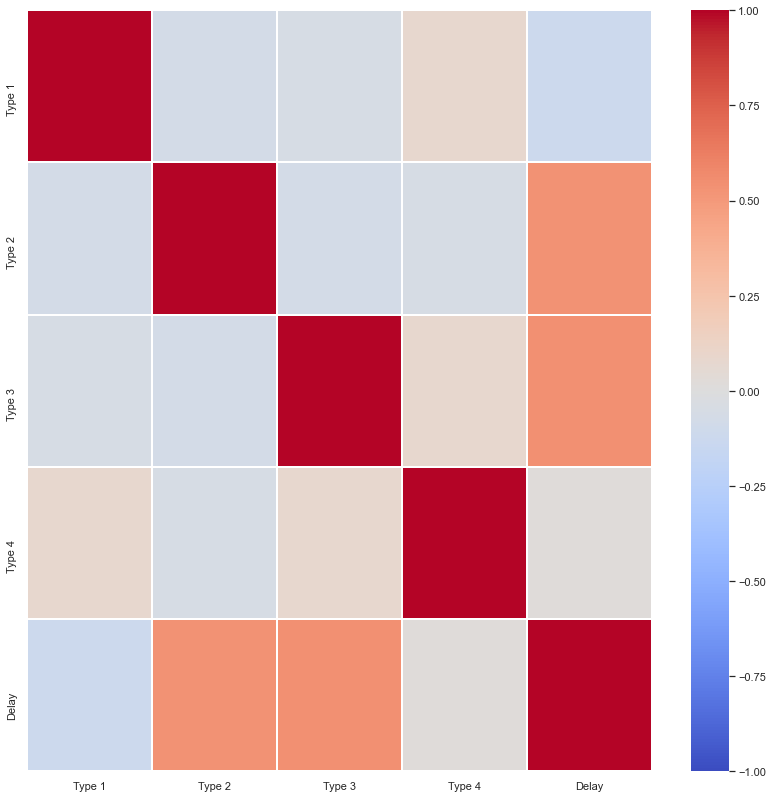

In [16]:
# Check Features for Colinearity

feature_corrs = colinearity_check(feature_names, logbook)

## Perform an All-Features All-Data Linear Fit as a Sanity Check

In [17]:
# Check All-Data Model with Rough All-Data All-Vars OLS Model

X = logbook[feature_names]
X.describe()
y = logbook['Total Hours']
y.value_counts()
lin_model = sm.OLS(y,X)
result = lin_model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:            Total Hours   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                              2147.
Date:                Fri, 21 May 2021   Prob (F-statistic):                   1.40e-229
Time:                        16:05:45   Log-Likelihood:                         -472.09
No. Observations:                 300   AIC:                                      954.2
Df Residuals:                     295   BIC:                                      972.7
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Split the Data into Train and Test Sets

In [18]:
# Split Data into Train, Test Data Sets

# Select dataset for analysis
X = logbook[feature_names]
# display(logbook.head())

y = logbook['Total Hours']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

# display(y)
# print(f'Training set value counts:\n{y_train.value_counts()}\n\nTest set value counts:\n{y_test.value_counts()}')

print(f'Training observations: {y_train.size} \tTesting observations: {y_test.size}')

Training observations: 225 	Testing observations: 75


## Train the Model

In [19]:
# Train the Model
model = LinearRegression()  # initialize the LinearRegression model

model.fit(X_train,y_train)  # we fit the model with the training data

#linear_pred = model.predict(X_test)  # make prediction with the fitted model

y_pred = model.predict(X_test)  # make prediction with the fitted model

# Score the model on the train set
print('Train score: {}\n'.format(model.score(X_train,y_train)))

# Score the model on the test set
print('Test score: {}\n'.format(model.score(X_test,y_test)))

# Calculate the overall accuracy of the model
print('Overall model accuracy: {}\n'.format(r2_score(y_test,y_pred)))

# Compute the mean squared error of the model
print('Mean Squared Error: {}'.format(mean_squared_error(y_test,y_pred)))

Train score: 0.7640340161261081

Test score: 0.7596988523071219

Overall model accuracy: 0.7596988523071219

Mean Squared Error: 1.3142981843679638


In [25]:
#display(y_train)
type(y_train)

pandas.core.series.Series

In [26]:
type(y_pred)

numpy.ndarray

In [27]:
y_train

259     9.7
37      2.4
97      7.6
191    10.6
135     5.2
118     6.7
160     7.8
264     9.1
214     4.0
238     8.2
76      9.3
212     5.1
225     5.3
255     2.3
237     3.5
282     7.7
44      4.0
272     5.7
189     2.1
152     8.9
158     7.7
101     5.7
54      4.2
181     6.5
18      6.5
281     9.0
250     7.5
126     8.7
171     5.5
71      5.0
227     8.1
245     2.1
205     7.7
288     6.2
215     8.4
154     6.6
159     0.5
33      7.2
83      2.2
249     4.1
60      1.6
167     4.7
280     9.9
110     5.0
21     10.1
29      8.1
146     8.2
16     14.6
56      6.7
75      3.9
109     6.2
175     9.3
201     8.1
161    11.0
4       5.0
96      5.9
166     3.1
61      8.1
67      6.4
137     4.4
198     9.6
262     5.6
279     7.6
40      8.6
268     5.3
13      5.6
107    10.0
220     8.7
3       4.5
157     5.0
125     9.2
24      6.7
30     12.2
77      9.1
291     6.7
210     7.6
19     10.2
254     9.0
241     8.3
266     5.1
80      7.3
51      6.4
2       7.5
235 

In [ ]:
print